In [117]:
import pandas as pd
import numpy as np
import bilby
import corner

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [81]:
# General settings
import matplotlib as mpl
mpl.rc_file('/Users/ulyanadupletsa/Documents/PhDThesisPlots/matplotlibrc')

mpl.rc('xtick', labelsize = 14) 
mpl.rc('ytick', labelsize = 14)

In [104]:
my_color = '#97a7a7'
my_color_darker = '#2f4f4f'
my_color2 = '#eba75f'
my_color2_darker = '#f6b26b'

In [105]:
PATH_TO_DATA = '/Users/ulyanadupletsa/Documents/PhDThesisData/Bilby4GWFish/'

In [141]:
def get_pe_in_component_masses(bilby_output, redshift, pe_params):
    posterior = bilby_output.posterior
    posterior['mass_1_source'] = posterior['chirp_mass'] * (1 + posterior['mass_ratio'])**(1/5) / posterior['mass_ratio']**(3/5) / (1 + redshift)
    posterior['mass_2_source'] = posterior['chirp_mass'] * (1 + posterior['mass_ratio'])**(1/5) * posterior['mass_ratio']**(2/5) / (1 + redshift)
    return posterior[pe_params]

In [ ]:
def plot_2corner(bilby_data, gwfish_data, injected_values, labels, title_labels, legend_title, plot_name, lbl_size=18, figsize=(6, 6), **kwargs):
    # Calculate the range dynamically with padding
    padding = 0.1  # Extend range by 10%
    data = np.vstack([gwfish_data, bilby_data])
    data_min = np.min(data, axis=0)
    data_max = np.max(data, axis=0)
    data_range = [(low - padding * (high - low), high + padding * (high - low)) for low, high in zip(data_min, data_max)]

    figure = corner.corner(
        gwfish_data, 
        color=my_color_darker, 
        truths=injected_values,
        range=data_range,  # Use calculated range with padding 
        labels=labels, 
        titles=title_labels, 
        rect=[0, 0, 1, 1],
        figsize=figsize,
        **kwargs
    )
    corner.corner(
        bilby_data, 
        color=my_color2,
        range=None, 
        fig=figure,
        **kwargs
    )

    # Add legend
    # Create proxy artists (dummy patches) for the datasets
    legend_patches = [
        mpatches.Patch(color=my_color_darker, label='GWFish Data'),
        mpatches.Patch(color=my_color2, label='Bilby Data')
    ]
    # Add legend to the figure
    figure.legend(
        handles=legend_patches,
        loc='upper center',  # Position the legend
        fontsize=lbl_size + 4,
        frameon=False,  # Disable the legend frame
        title='- ' + legend_title + ' -',  # Add a title to the legend
        title_fontsize=lbl_size + 6  # Set the title font size
    )
    
    # Adjust tick parameters for all axes
    for ax in figure.get_axes():
        ax.tick_params(axis='both', labelsize=lbl_size)
        title = ax.get_title()  # Get current title
        new_title = title.split("=")[-1].strip()  # Extract only the value
        ax.set_title(new_title, fontsize=21)  # Update the title
        # Remove variable names from the titles
    # Force a tight layout by adjusting subplot spacing
    figure.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95)
    # Save the plot to a file
    plt.savefig(f'plots/{plot_name}.pdf', bbox_inches='tight')  
    # Display the plot
    plt.show()
    plt.close()

In [146]:
default_kwargs = dict(
            bins=50, smooth=0.9,
            smooth1d=0.8,
            show_titles=True,
            title_kwargs=dict(fontsize=24),
            title_fmt='.2f',
            title_quantiles=[0.16,0.5,0.84],
            label_kwargs = dict(color = 'black', fontsize = 24),
            truth_color='black', quantiles=[0.16, 0.84],
            levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
            plot_density=False, plot_datapoints=True, fill_contours=True,
            max_n_ticks=3, labelpad=0.1
)

In [147]:
corner_lbs = ['$m_{1, \\rm src}$ [$M_{\odot}$]', 
              '$m_{2, \\rm src}$ [$M_{\odot}$]', 
              '$d_L$ [Mpc]',
              '$\iota$ [rad]',
              'RA [rad]',
              'DEC [rad]',
              '$\Psi$ [rad]'
            ]
title_labels = ['', '', '', '', '', '', ''] 

In [173]:
input_files = ['5plus10', '15plus30', '30plus60', '30plus60_with_5plus10', '30plus60_SNR8']
legend_titles = ['SIGNAL 1', 'SIGNAL 2', 'SIGNAL 3', 'SIGNAL 4', 'SIGNAL 3 (SNR 8)']
fig_labels = ['corner_5plus10', 'corner_15plus30', 'corner_30plus60', 'corner_30plus60_with_5plus10', 'corner_30plus60_SNR8']

In [174]:
corner_params = ['mass_1_source', 'mass_2_source', 'luminosity_distance', 'theta_jn', 'ra', 'dec', 'psi']

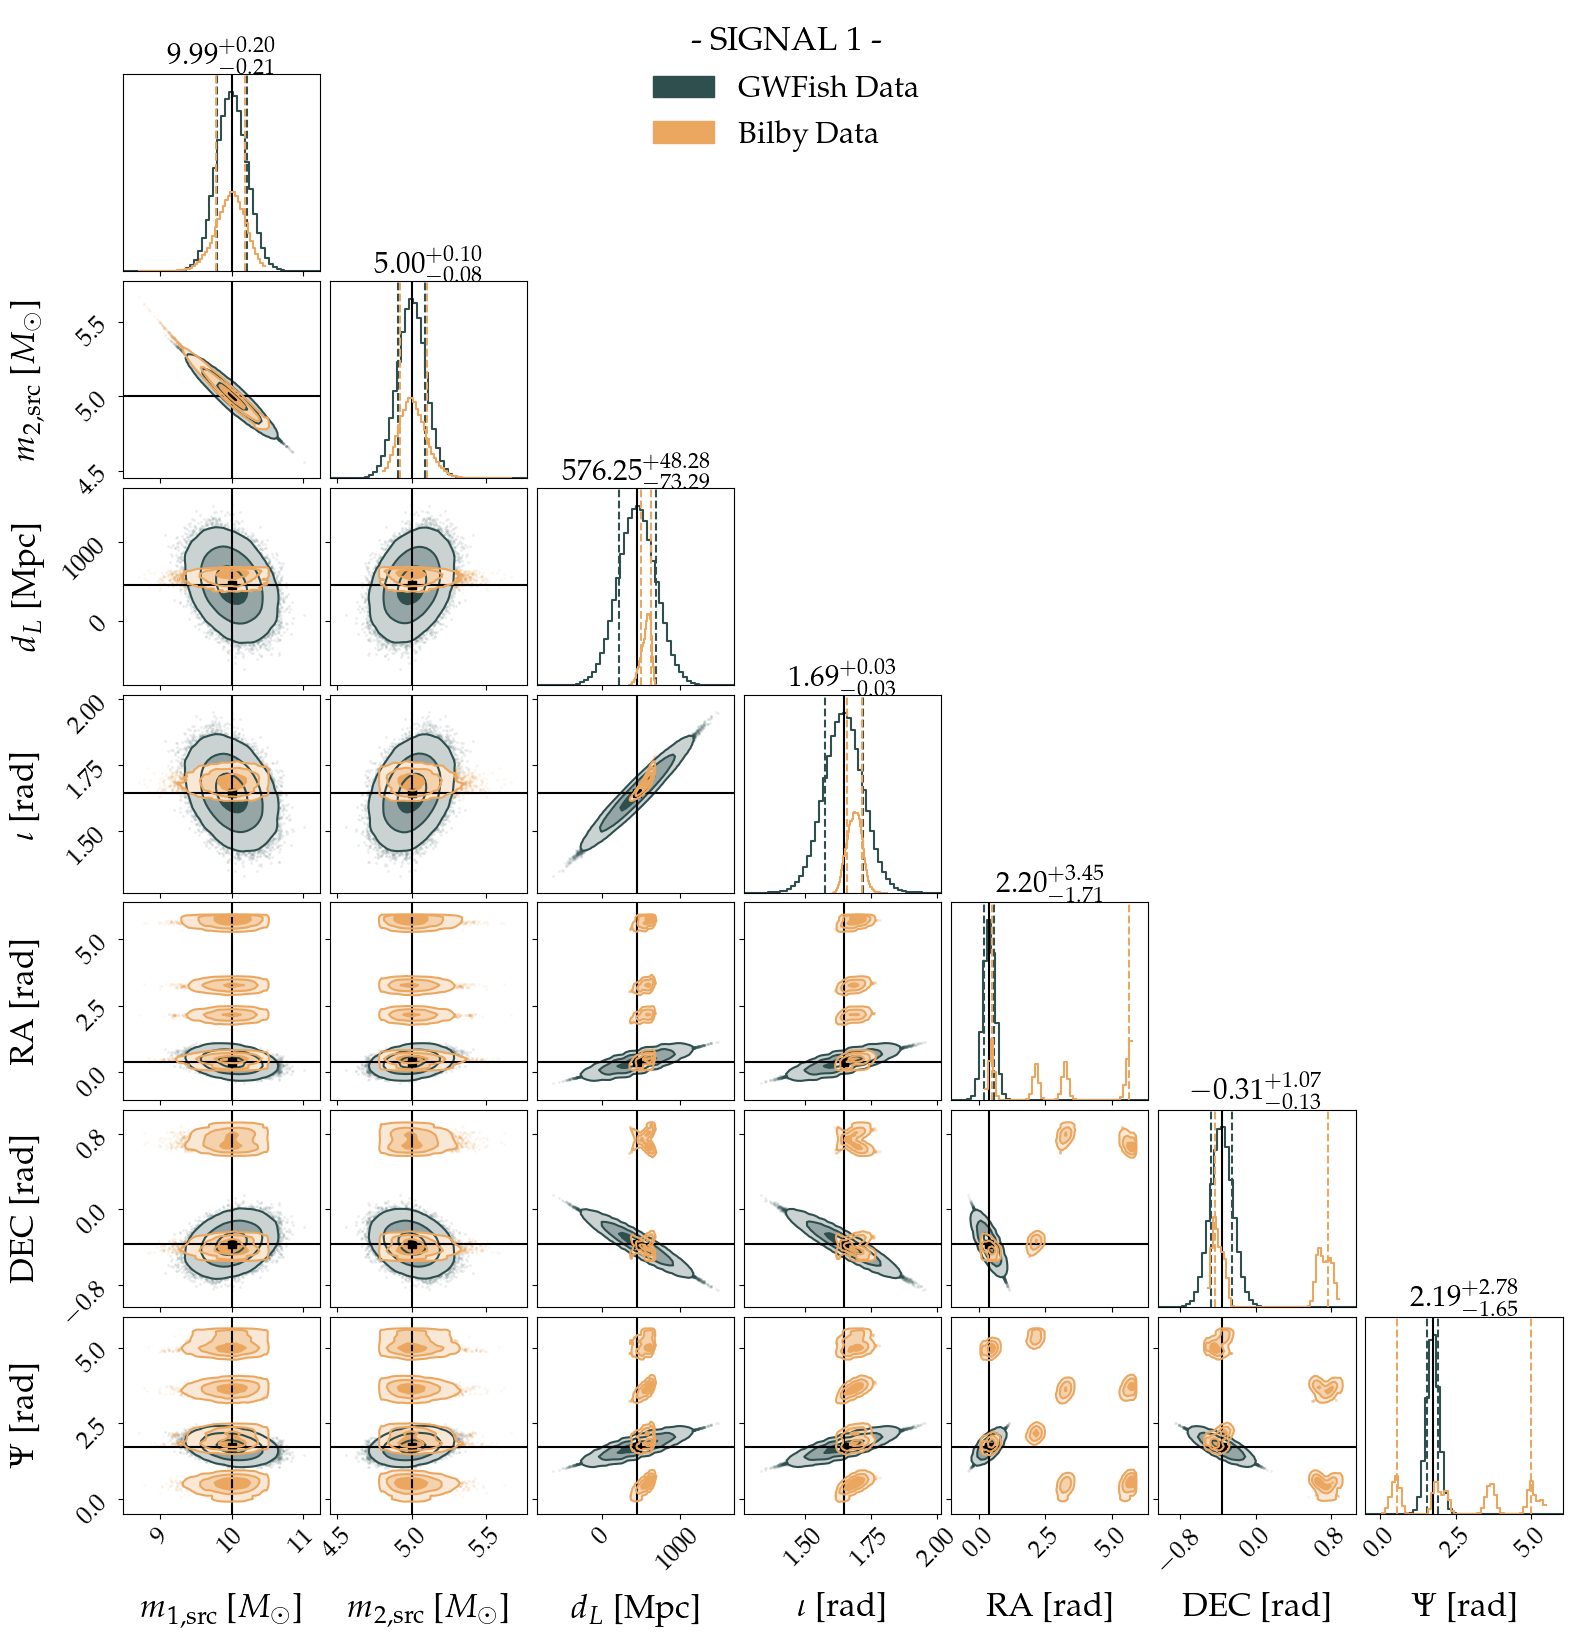

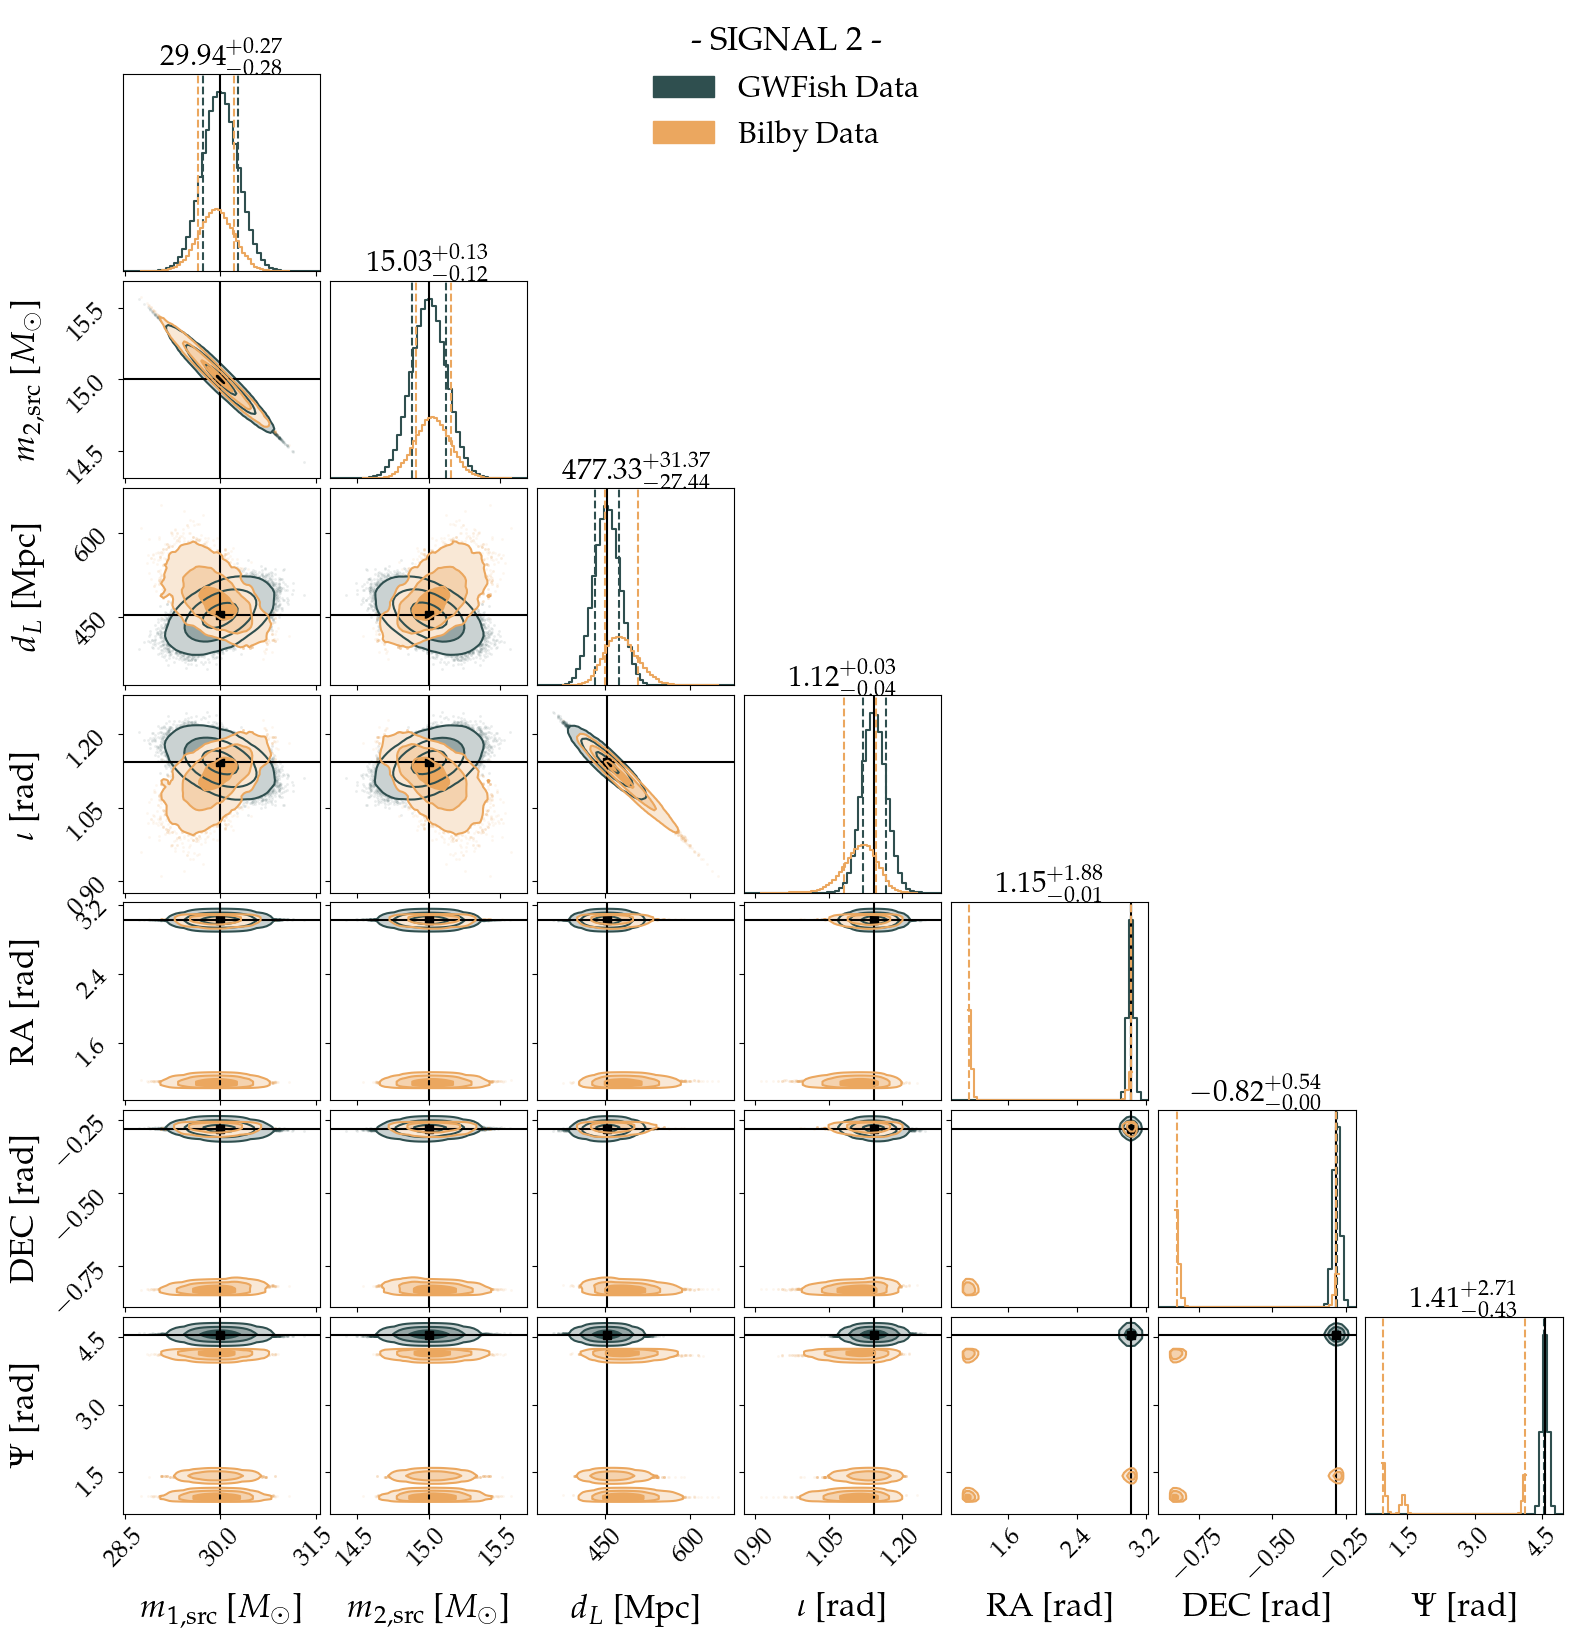

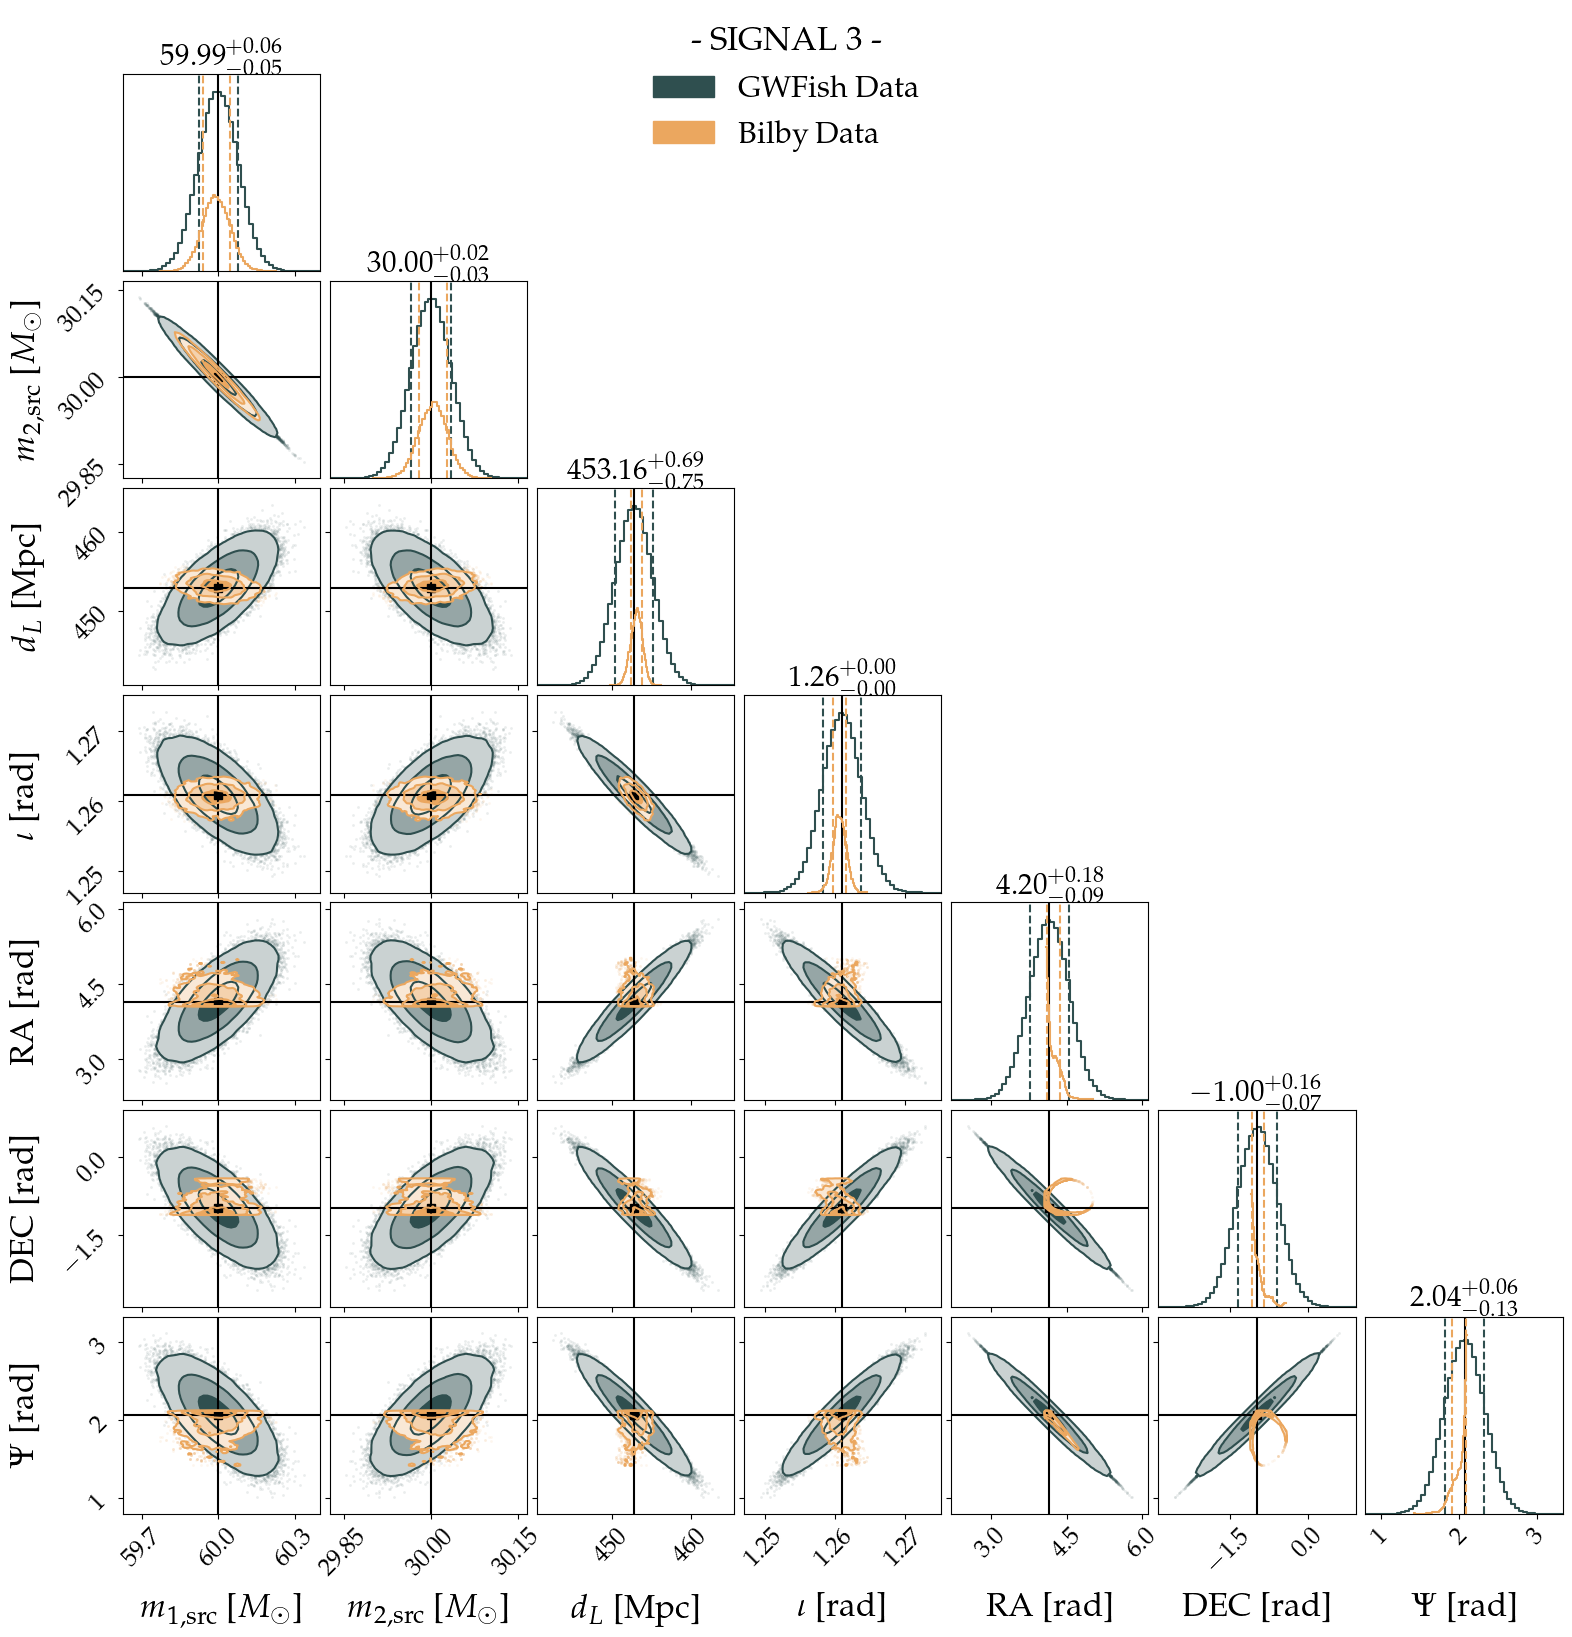

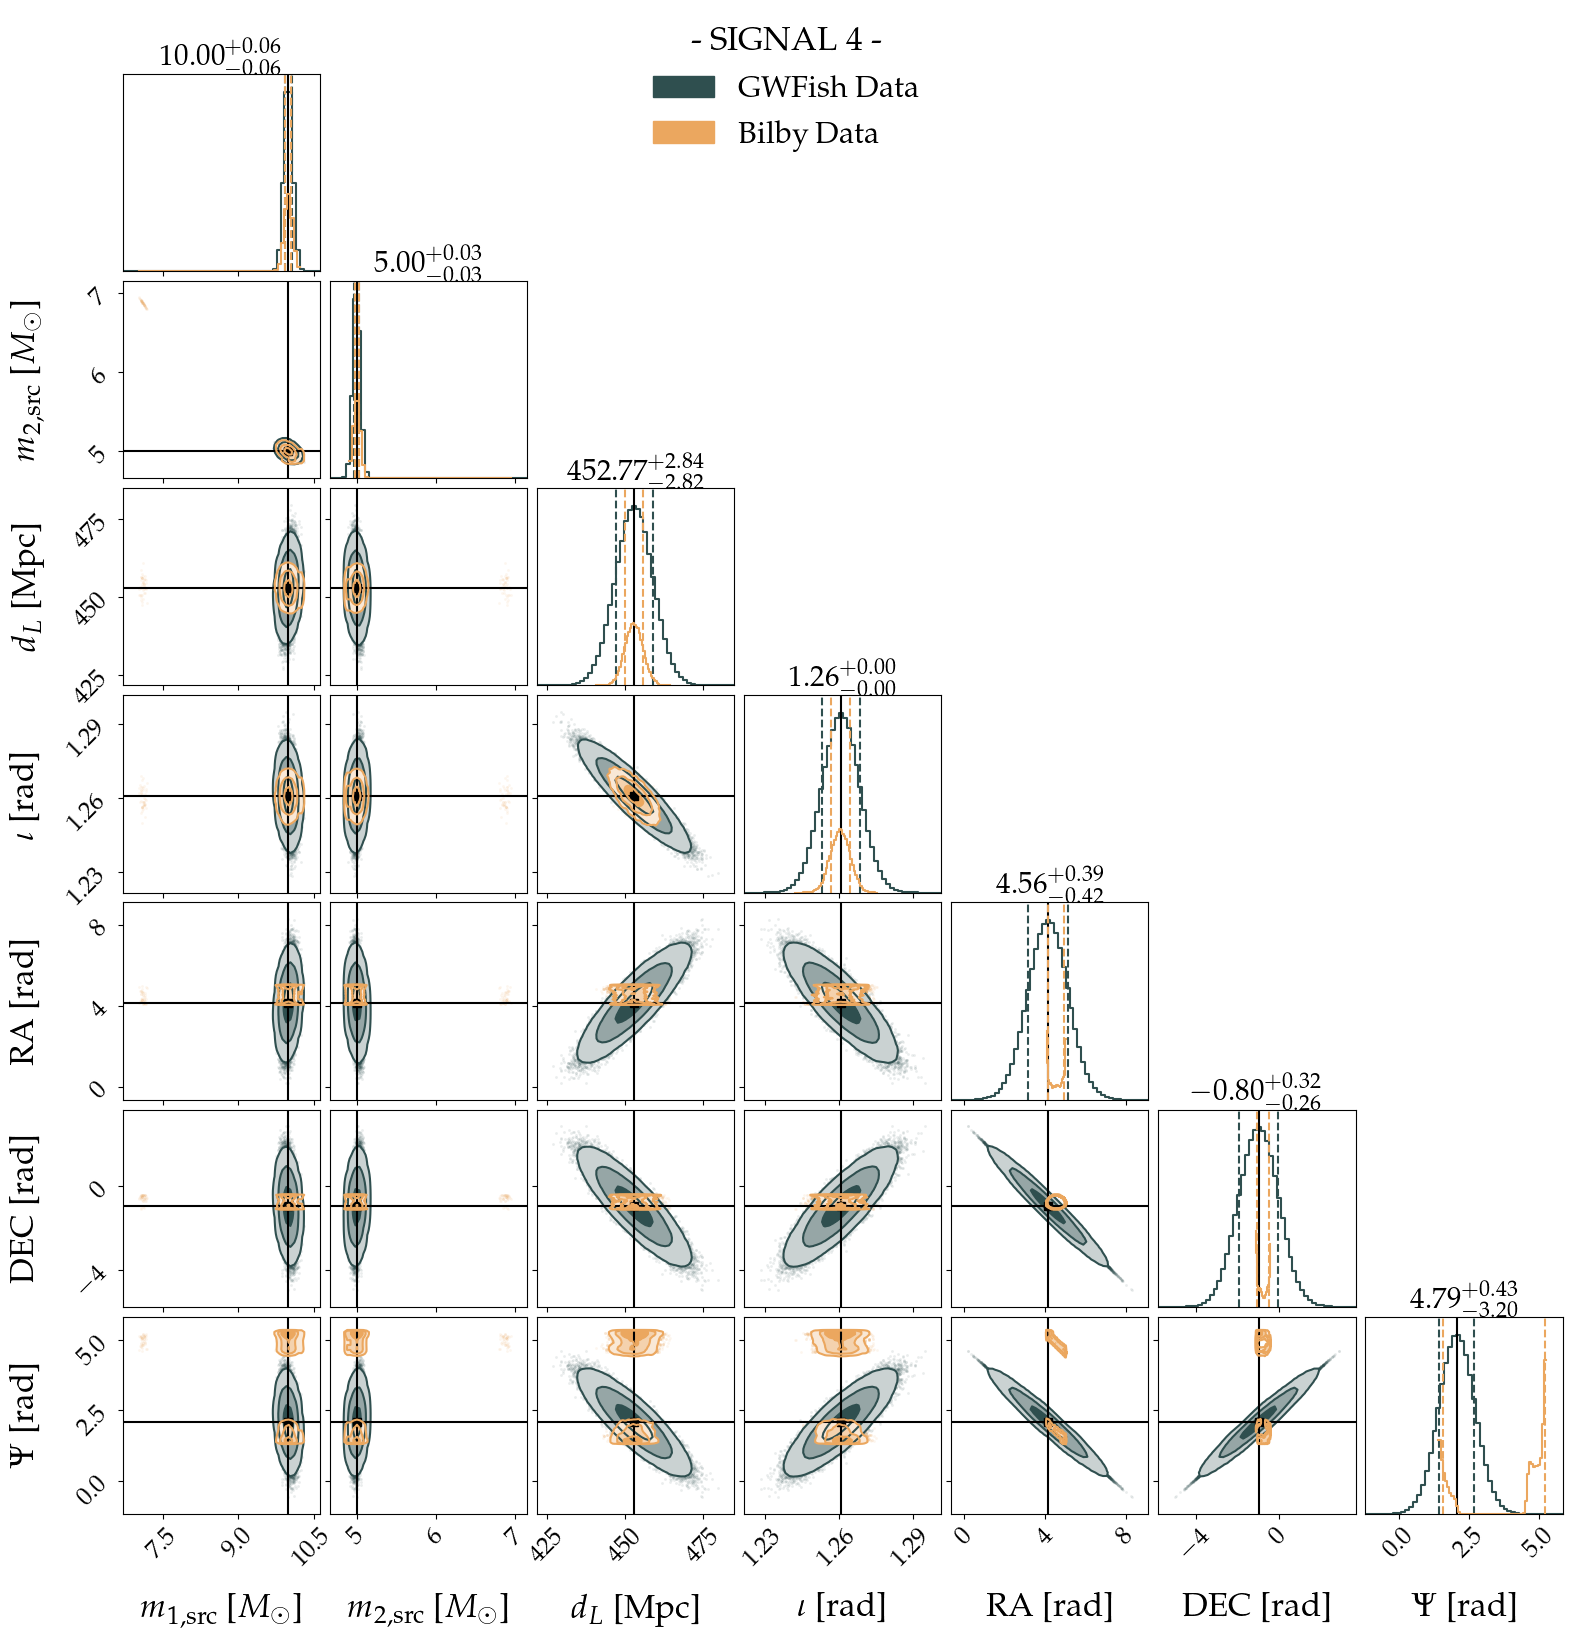

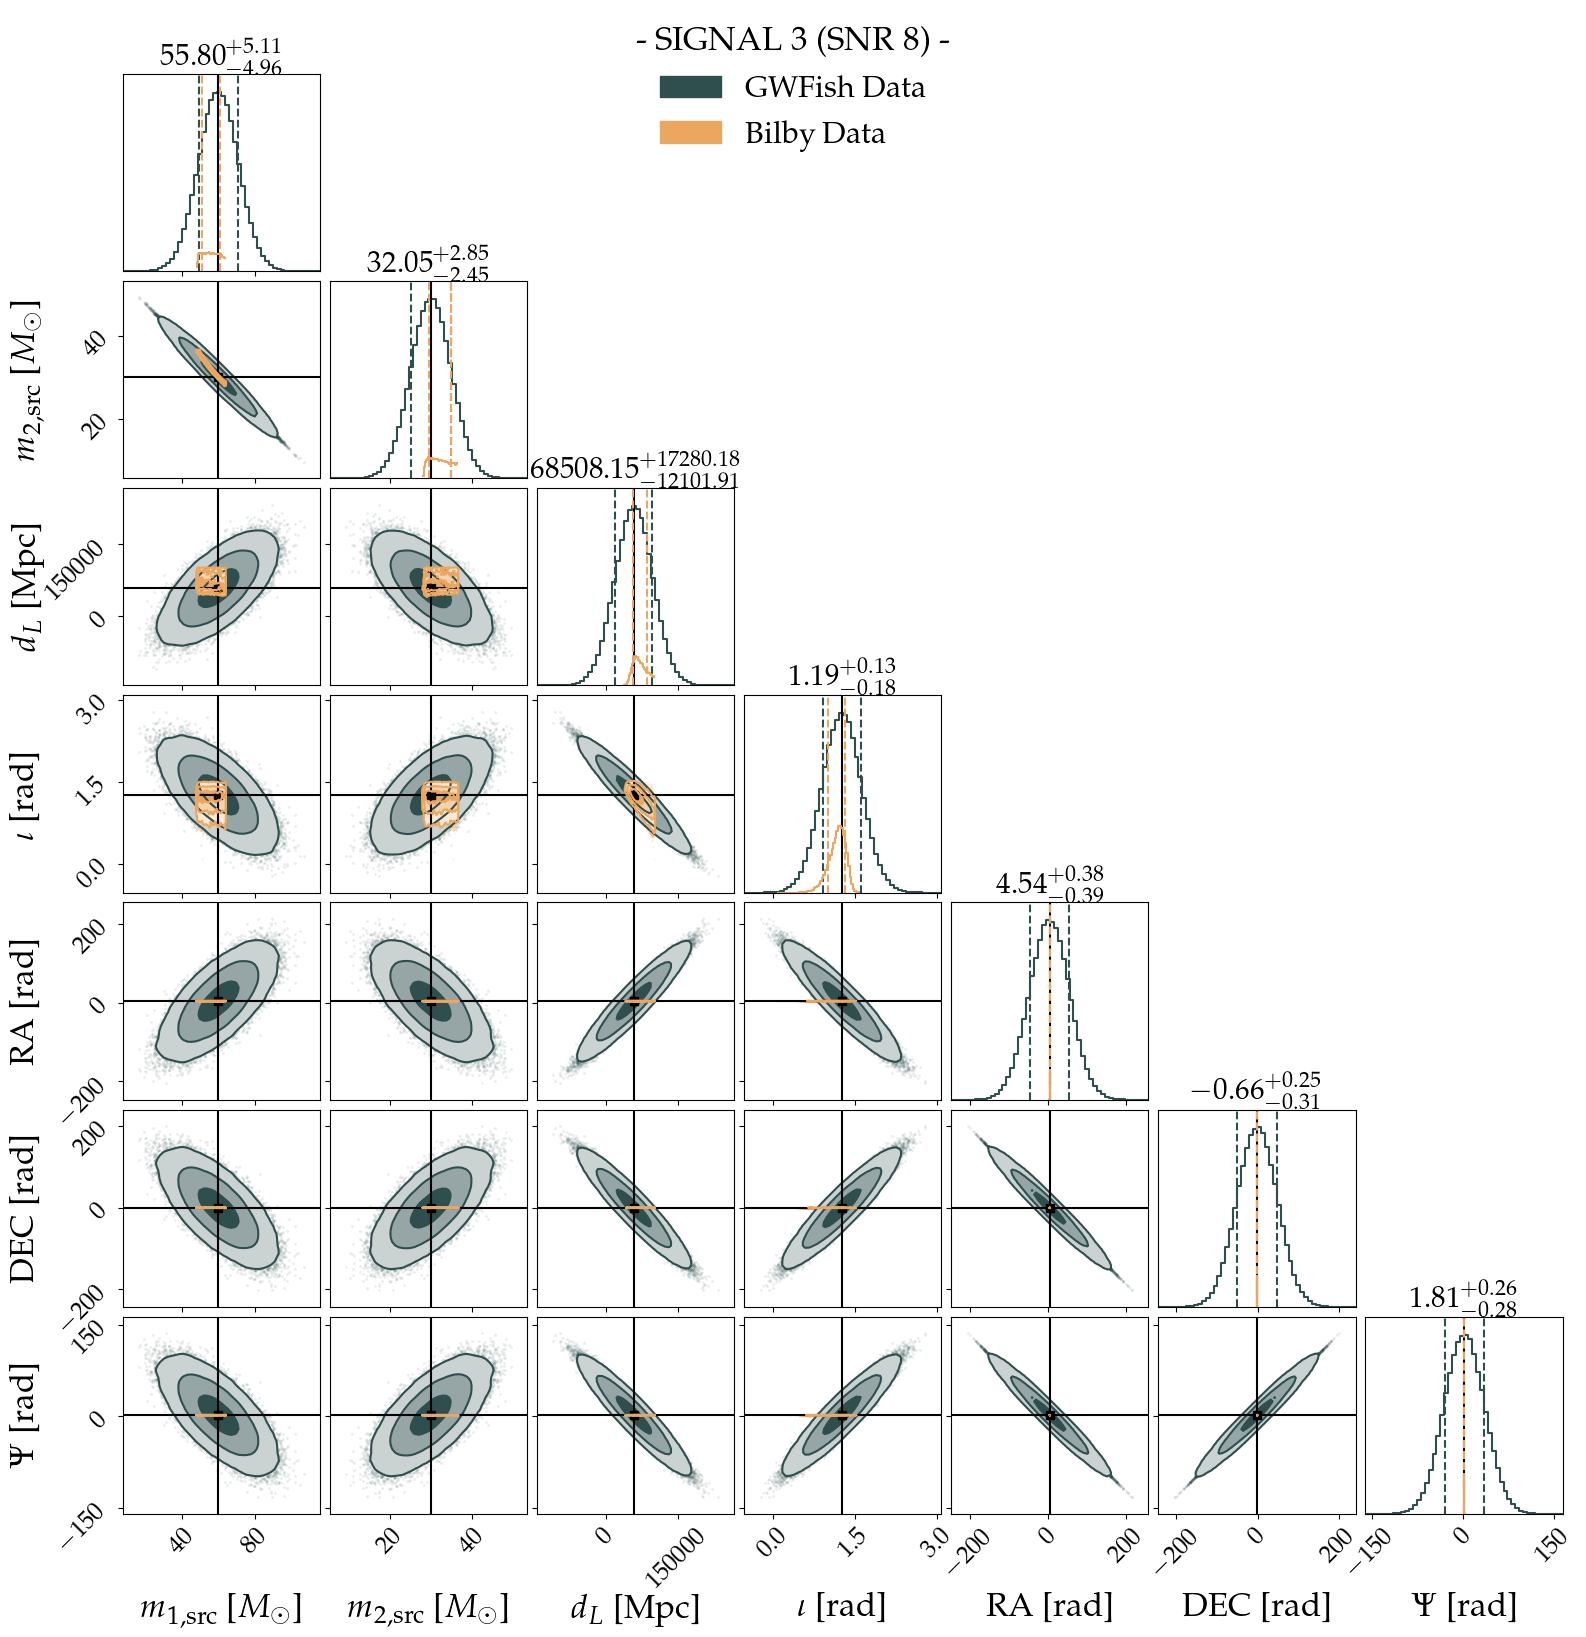

In [176]:
for i, input in enumerate(input_files):
    injections = pd.read_hdf(PATH_TO_DATA + 'CBC_pop_' + input + '.hdf5')
    covm = np.loadtxt(PATH_TO_DATA + 'Inverse_Fisher_' + input + '.txt')
    bilby_output = bilby.core.result.read_in_result(PATH_TO_DATA + input +'_result.json')
    pe_bilby = get_pe_in_component_masses(bilby_output, injections['redshift'].to_numpy(), corner_params)
    np.random.seed(42)
    pe_gwfish = np.random.multivariate_normal(injections[corner_params].iloc[0].to_numpy(), covm, 100000)
    # corner plot
    plot_2corner(pe_bilby, pe_gwfish, injections[corner_params].iloc[0].to_numpy(), corner_lbs, title_labels, 
                 legend_titles[i], fig_labels[i], lbl_size=18, figsize=(10, 10), **default_kwargs)
